# Chapter 8. Using convolutions to generalize
This chapter covers
* Understanding convolution
* Building a convolutional neural network
* Creating custom `nn.Module` subclasses
* The difference between the module and functional APIs
* Design choices for neural networks

## 8.1 The case for convolutions
In this section, we’ll see how convolutions deliver locality and translation invariance.
We’ll do so by taking a close look at the formula defining convolutions and applying it
using pen and paper—but don’t worry, the gist will be in pictures, not formulas.
We said earlier that taking a 1D view of our input image and multiplying it by an
`n_output_features × n_input_features` weight matrix, as is done in `nn.Linear` ,
means for each channel in the image, computing a weighted sum of all the pixels multiplied by a set of weights, one per output feature.

We also said that, if we want to recognize patterns corresponding to objects, like an
airplane in the sky, we will likely need to look at how nearby pixels are arranged, and
we will be less interested in how pixels that are far from each other appear in combination. Essentially, it doesn’t matter if our image of a Spitfire has a tree or cloud or kite in the corner or not.

In order to translate this intuition into mathematical form, we could compute the
weighted sum of a pixel with its immediate neighbors, rather than with all other pixels
in the image. This would be equivalent to building weight matrices, one per output
feature and output pixel location, in which all weights beyond a certain distance from
a center pixel are zero. This will still be a weighted sum: that is, a linear operation.

### 8.1.1 What convolutions do
We identified one more desired property earlier: we would like these localized patterns
to have an effect on the output regardless of their location in the image: that is, to be
translation invariant. To achieve this goal in a matrix applied to the image-as-a-vector we
used in chapter 7 would require implementing a rather complicated pattern of weights
(don’t worry if it is too complicated; it’ll get better shortly): most of the weight matrix
would be zero (for entries corresponding to input pixels too far away from the output
pixel to have an influence). For other weights, we would have to find a way to keep
entries in sync that correspond to the same relative position of input and output pixels.
This means we would need to initialize them to the same values and ensure that all these
tied weights stayed the same while the network is updated during training. This way, we
would ensure that weights operate in neighborhoods to respond to local patterns, and
local patterns are identified no matter where they occur in the image.

Of course, this approach is more than impractical. Fortunately, there is a readily
available, local, translation-invariant linear operation on the image: a `convolution`. We
can come up with a more compact description of a convolution, but what we are going
to describe is exactly what we just delineated—only taken from a different angle.

Convolution, or more precisely, `discrete convolution` (there’s an analogous continuous version that we won’t go into here), is defined for a 2D image as the scalar product of a weight matrix, the `kernel`, with every neighborhood in the input. Consider a
3 × 3 kernel (in deep learning, we typically use small kernels; we’ll see why later on) as
a 2D tensor

```
weight = torch.tensor([[w00, w01, w02],
                       [w10, w11, w12],
                       [w20, w21, w22]])
```
and a 1-channel, MxN image:
```
mage = torch.tensor([[i00,i01,i02,i03,...,i0N],
                     [i10,i11,i12,i13,...,i1N],
                     [i20,i21,i22,i23,...,i2N],
                     [i30,i31,i32,i33,...,i3N],
                     ...
                     [iM0,iM1m iM2, iM3, ..., iMN]])
```
We can compute an element of the output image (without bias) as follows:
```
o11 = i11 * w00 + i12 * w01 + i22 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22
```

![](images/8.1.png)

Figure 8.1 shows this computation in action.
That is, we “translate” the kernel on the `i11` location of the input image, and we
multiply each weight by the value of the input image at the corresponding location.
Thus, the output image is created by translating the kernel on all input locations and
performing the weighted sum. For a multichannel image, like our RGB image, the
weight matrix would be a 3 × 3 × 3 matrix: one set of weights for every channel, contributing together to the output values.

Note that, just like the elements in the `weight` matrix of `nn.Linear` , the weights in
the kernel are not known in advance, but they are initialized randomly and updated
through backpropagation. Note also that the same kernel, and thus each weight in the
kernel, is reused across the whole image. Thinking back to autograd, this means the use
of each weight has a history spanning the entire image. Thus, the derivative of the loss
with respect to a convolution weight includes contributions from the entire image.

It’s now possible to see the connection to what we were stating earlier: a convolution is
equivalent to having multiple linear operations whose weights are zero almost everywhere except around individual pixels and that receive equal updates during training.
Summarizing, by switching to convolutions, we get
* Local operations on neighborhoods
* Translation invariance
* Models with a lot fewer parameters

The key insight underlying the third point is that, with a convolution layer, the number of parameters depends not on the number of pixels in the image, as was the case
in our fully connected model, but rather on the size of the convolution kernel (3 × 3,
5 × 5, and so on) and on how many convolution filters (or output channels) we decide
to use in our model.

## 8.2 Convolutions in action
Well, it looks like we’ve spent enough time down a rabbit hole! Let’s see some PyTorch
in action on our birds versus airplanes challenge. The `torch.nn` module provides convolutions for 1, 2, and 3 dimensions: `nn.Conv1d` for time series, `nn.Conv2d` for images, and `nn.Conv3d` for volumes or videos.

For our CIFAR-10 data, we’ll resort to `nn.Conv2d` . At a minimum, the arguments we
provide to `nn.Conv2d` are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output
features, and the size of the kernel. For instance, for our first convolutional module,
we’ll have 3 input features per pixel (the RGB channels) and an arbitrary number of
channels in the output—say, 16. The more channels in the output image, the more the
capacity of the network. We need the channels to be able to detect many different types
of features. Also, because we are randomly initializing them, some of the features we’ll
get, even after training, will turn out to be useless. 2 Let’s stick to a kernel size of 3 × 3.

It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever `kernel_size=3` is specified for a 2D convo-
lution, it means 3 × 3 (provided as a tuple (3, 3) in Python). For a 3D convolution, it
means 3 × 3 × 3. The CT scans we will see in part 2 of the book have a different voxel
(volumetric pixel) resolution in one of the three axes. In such a case, it makes sense to
consider kernels that have a different size for the exceptional dimension. But for now,
we stick with having the same size of convolutions across all dimensions:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [7]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [8]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [9]:
conv = nn.Conv2d(3, 16, kernel_size=3) # Instead of the shortcut kernel_size=3, we
                                       # could equivalently pass in the tuple that we
                                       # see in the output: kernel_size=(3, 3).
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

What do we expect to be the shape of the weight tensor? The kernel is of size 3 × 3, so
we want the weight to consist of 3 × 3 parts. For a single output pixel value, our kernel
would consider, say, `in_ch = 3` input channels, so the weight component for a single
output pixel value (and by translation the invariance for the entire output channel) is
of shape `in_ch × 3 × 3`. Finally, we have as many of those as we have output channels,
here `out_ch = 16`, so the complete weight tensor is `out_ch × in_ch × 3 × 3`, in our case
16 × 3 × 3 × 3. The bias will have size 16 (we haven’t talked about bias for a while for
simplicity, but just as in the linear module case, it’s a constant value we add to each
channel of the output image). Let’s verify our assumptions:

In [10]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

We can see how convolutions are a convenient choice for learning from images. We
have smaller models looking for local patterns whose weights are optimized across the
entire image.

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image. In our case, both the kernel weights and the bias `conv.weight` are initialized randomly, so the output image will not be particularly meaningful. As usual, we need to add the zeroth batch dimension with
`unsqueeze` if we want to call the `conv` module with one input image, since `nn.Conv2d`
expects a B × C × H × W shaped tensor as input:

In [11]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We’re curious, so we can display the output, shown in figure 8.2:

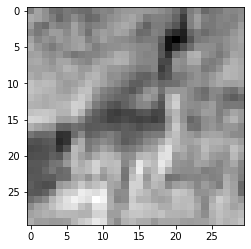

In [12]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Wait a minute. Let’s take a look a the size of `output` : it’s `torch.Size([1, 16, 30,
30])` . Huh; we lost a few pixels in the process. How did that happen?

### 8.2.1 Padding the boundary
The fact that our output image is smaller than the input is a side effect of deciding what
to do at the boundary of the image. Applying a convolution kernel as a weighted sum
of pixels in a 3 × 3 neighborhood requires that there are neighbors in all directions. If
we are at i00, we only have pixels to the right of and below us. By default, PyTorch will
slide the convolution kernel within the input picture, getting `width - kernel_width + 1`
horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, 3//2 = 1) smaller on each side.
This explains why we’re missing two pixels in each dimension.

However, PyTorch gives us the possibility of **padding** the image by creating **ghost** pixels around the border that have value zero as far as the convolution is concerned. Figure 8.3 shows padding in action.
In our case, specifying `padding=1` when `kernel_size=3` means i00 has an extra set
of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image. 3 The net result is that the output has
now the exact same size as the input:

In [13]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

![](images/8.2.png)
Note that the sizes of `weight` and `bias` don’t change, regardless of whether padding is
used.

There are two main reasons to pad convolutions. First, doing so helps us separate
the matters of convolution and changing image sizes, so we have one less thing to
remember. And second, when we have more elaborate structures such as skip con-
nections (discussed in section 8.5.3) or the U-Nets we’ll cover in part 2, we want the
tensors before and after a few convolutions to be of compatible size so that we can
add them or take differences.

### 8.2.2 Detecting features with convolutions
We said earlier that `weight` and `bias` are parameters that are learned through back-
propagation, exactly as it happens for `weight` and `bias` in `nn.Linear` . However, we can
play with convolution by setting weights by hand and see what happens.
Let’s first zero out `bias` , just to remove any confounding factors, and then set
`weights` to a constant value so that each pixel in the output gets the mean of its neighbors. For each 3 × 3 neighborhood:

In [14]:
with torch.no_grad():
    conv.bias.zero_()
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

We could have gone with `conv.weight.one_()` —that would result in each pixel in the
output being the sum of the pixels in the neighborhood. Not a big difference, except
that the values in the output image would have been nine times larger.

Anyway, let’s see the effect on our CIFAR image:

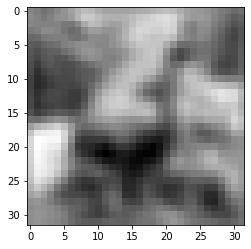

In [15]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

As we could have predicted, the filter produces a blurred version of the image, as shown
in figure 8.4. After all, every pixel of the output is the average of a neighborhood of the
input, so pixels in the output are correlated and change more smoothly.

Next, let’s try something different. The following kernel may look a bit mysterious
at first:

In [16]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

Working out the weighted sum for an arbitrary pixel in position 2,2, as we did earlier
for the generic convolution kernel, we get
```
o22 = i13 - i11 +
      i23 - i21 +
      i33 - i31
```

which performs the difference of all pixels on the right of i22 minus the pixels on the
left of i22. If the kernel is applied on a vertical boundary between two adjacent regions
of different intensity, o22 will have a high value. If the kernel is applied on a region of
uniform intensity, o22 will be zero. It’s an **edge-detection** kernel: the kernel highlights the
vertical edge between two horizontally adjacent regions.
Applying the convolution kernel to our image, we see the result shown in figure
8.5. 

![](images/8.5.png)

As expected, the convolution kernel enhances the vertical edges. We could build lots more elaborate filters, such as for detecting horizontal or diagonal edges, or crosslike or checkerboard patterns, where “detecting” means the output has a high magnitude. In fact, the job of a computer vision expert has historically been to come up with the most effective combination of filters so that certain features are highlighted in images and objects can be recognized.

With deep learning, we let kernels be estimated from data in whatever way the dis-
crimination is most effective: for instance, in terms of minimizing the negative cross-
entropy loss between the output and the ground truth that we introduced in section
7.2.5. From this angle, the job of a convolutional neural network is to estimate the ker-
nel of a set of filter banks in successive layers that will transform a multichannel image
into another multichannel image, where different channels correspond to different
features (such as one channel for the average, another channel for vertical edges, and
so on). Figure 8.6 shows how the training automatically learns the kernels.

![](images/8.6.png)

### 8.2.3 Looking further with depth and pooling
This is all well and good, but conceptually there’s an elephant in the room. We got all
excited because by moving from fully connected layers to convolutions, we achieve
locality and translation invariance. Then we recommended the use of small kernels,
like 3 × 3, or 5 × 5: that’s peak locality, all right. What about the **big picture**? How do we
know that all structures in our images are 3 pixels or 5 pixels wide? Well, we don’t,
because they aren’t. And if they aren’t, how are our networks going to be equipped to
see those patterns with larger scope? This is something we’ll really need if we want to solve our birds versus airplanes problem effectively, since although CIFAR-10 images
are small, the objects still have a (wing-)span several pixels across.

One possibility could be to use large convolution kernels. Well, sure, at the limit we
could get a 32 × 32 kernel for a 32 × 32 image, but we would converge to the old fully
connected, affine transformation and lose all the nice properties of convolution.
Another option, which is used in convolutional neural networks, is stacking one con-
volution after the other and at the same time downsampling the image between suc-
cessive convolutions.

**FROM LARGE TO SMALL : DOWNSAMPLING**

Downsampling could in principle occur in different ways. Scaling an image by half is
the equivalent of taking four neighboring pixels as input and producing one pixel as
output. How we compute the value of the output based on the values of the input is
up to us. We could

* **Average the four pixels**. This **average pooling** was a common approach early on but has fallen out of favor somewhat.
* **Take the maximum of the four pixels**. This approach, called **max pooling**, is currently the most commonly used approach, but it has a downside of discarding the other three-quarters of the data.
* **Perform a strided convolution, where only every Nth pixel is calculated**. A 3 × 4 convolu- tion with stride 2 still incorporates input from all pixels from the previous layer. The literature shows promise for this approach, but it has not yet supplanted max pooling

We will be focusing on max pooling, illustrated in figure 8.7, going forward. The fig-
ure shows the most common setup of taking non-overlapping 2 x 2 tiles and taking the
maximum over each of them as the new pixel at the reduced scale.

![](images/8.7.png)
Intuitively, the output images from a convolution layer, especially since they are fol-
lowed by an activation just like any other linear layer, tend to have a high magnitude where certain features corresponding to the estimated kernel are detected (such as
vertical lines). By keeping the highest value in the 2 × 2 neighborhood as the downs-
ampled output, we ensure that the features that are found survive the downsampling,
at the expense of the weaker responses.

Max pooling is provided by the `nn.MaxPool2d` module (as with convolution, there are
versions for 1D and 3D data). It takes as input the size of the neighborhood over which
to operate the pooling operation. If we wish to downsample our image by half, we’ll want
to use a size of 2. Let’s verify that it works as expected directly on our input image:

In [17]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

**COMBINING CONVOLUTIONS AND DOWNSAMPLING FOR GREAT GOOD**
Let’s now see how combining convolutions and downsampling can help us recognize
larger structures. In figure 8.8, we start by applying a set of 3 × 3 kernels on our 8 × 8
image, obtaining a multichannel output image of the same size. Then we scale down
the output image by half, obtaining a 4 × 4 image, and apply another set of 3 × 3 ker-
nels to it. This second set of kernels operates on a 3 × 3 neighborhood of something
that has been scaled down by half, so it effectively maps back to 8 × 8 neighborhoods
of the input. In addition, the second set of kernels takes the output of the first set of
kernels (features like averages, edges, and so on) and extracts additional features on
top of those.

So, on one hand, the first set of kernels operates on small neighborhoods on first-
order, low-level features, while the second set of kernels effectively operates on wider
neighborhoods, producing features that are compositions of the previous features.
This is a very powerful mechanism that provides convolutional neural networks with
the ability to see into very complex scenes—much more complex than our 32 × 32
images from the CIFAR-10 dataset.

![](images/8.8.png)

>**The receptive field of output pixels** \
When the second 3 × 3 convolution kernel produces 21 in its conv output in figure
8.8, this is based on the top-left 3 × 3 pixels of the first max pool output. They, in turn,
correspond to the 6 × 6 pixels in the top-left corner in the first conv output, which in
turn are computed by the first convolution from the top-left 7 × 7 pixels. So the pixel
in the second convolution output is influenced by a 7 × 7 input square. The first
convolution also uses an implicitly “padded” column and row to produce the output in
the corner; otherwise, we would have an 8 × 8 square of input pixels informing a given
pixel (away from the boundary) in the second convolution’s output. In fancy language,
we say that a given output neuron of the 3 × 3-conv, 2 × 2-max-pool, 3 × 3-conv
construction has a receptive field of 8 × 8.

### 8.2.4 Putting it all together for our network
With these building blocks in our hands, we can now proceed to build our convolu-
tional neural network for detecting birds and airplanes. Let’s take our previous fully
connected model as a starting point and introduce nn.Conv2d and nn.MaxPool2d as
described previously:

In [18]:
model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.Tanh(),
        nn.MaxPool2d(2),
        # ...
        )

The first convolution takes us from 3 RGB channels to 16, thereby giving the network
a chance to generate 16 independent features that operate to (hopefully) discriminate low-level features of birds and airplanes. Then we apply the `Tanh` activation function. The resulting 16-channel 32 × 32 image is pooled to a 16-channel 16 × 16 image
by the first `MaxPool3d` . At this point, the downsampled image undergoes another convolution that generates an 8-channel 16 × 16 output. With any luck, this output will
consist of higher-level features. Again, we apply a `Tanh` activation and then pool to an
8-channel 8 × 8 output.

Where does this end? After the input image has been reduced to a set of 8 × 8 features, we expect to be able to output some probabilities from the network that we can
feed to our negative log likelihood. However, probabilities are a pair of numbers in a
1D vector (one for airplane, one for bird), but here we’re still dealing with multichannel 2D features.

Thinking back to the beginning of this chapter, we already know what we need to
do: turn the 8-channel 8 × 8 image into a 1D vector and complete our network with a
set of fully connected layers:

In [19]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3,padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3,padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...  Warning: Something important is missing here!
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

This code gives us a neural network as shown in figure 8.9.

![](images/8.9.png)

Ignore the “something missing” comment for a minute. Let’s first notice that the size
of the linear layer is dependent on the expected size of the output of `MaxPool2d`: $8 × 8
× 8 = 512$. Let’s count the number of parameters for this small model:

In [20]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

That’s very reasonable for a limited dataset of such small images. In order to increase
the capacity of the model, we could increase the number of output channels for the
convolution layers (that is, the number of features each convolution layer generates),
which would lead the linear layer to increase its size as well.

We put the “Warning” note in the code for a reason. The model has zero chance of
running without complaining:

In [21]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

Admittedly, the error message is a bit obscure, but not too much so. We find references to `linear` in the traceback: looking back at the model, we see that only module
that has to have a $512 × 32$ tensor is `nn.Linear(512, 32)` , the first linear module after
the last convolution block.

What’s missing there is the reshaping step from an 8-channel $8 × 8$ image to a $512-
element$, 1D vector (1D if we ignore the batch dimension, that is). This could be
achieved by calling view on the output of the last `nn.MaxPool2d` , but unfortunately, we
don’t have any explicit visibility of the output of each module when we use
`nn.Sequential`.

## 8.3 Subclassing nn.Module
At some point in developing neural networks, we will find ourselves in a situation where
we want to compute something that the premade modules do not cover. Here, it is some-
thing very simple like reshaping, 5 ; but in section 8.5.3, we use the same construction to
implement residual connections. So in this section, we learn how to make our own
`nn.Module` subclasses that we can then use just like the prebuilt ones or `nn.Sequential`.

When we want to build models that do more complex things than just applying
one layer after another, we need to leave `nn.Sequential` for something that gives us
added flexibility. PyTorch allows us to use any computation in our model by subclass-
ing `nn.Module`.

In order to subclass `nn.Module` , at a minimum we need to define a `forward` function
that takes the inputs to the module and returns the output. This is where we define our
module’s computation. The name `forward` here is reminiscent of a distant past, when
modules needed to define both the forward and backward passes we met in section
5.5.1. With PyTorch, if we use standard `torch` operations, autograd will take care of the
backward pass automatically; and indeed, an `nn.Module` never comes with a `backward`.

Typically, our computation will use other modules—premade like convolutions or
customized. To include these submodules, we typically define them in the constructor
`__init__` and assign them to `self` for use in the `forward` function. They will, at the
same time, hold their parameters throughout the lifetime of our module. Note that you
need to call `super().__init__()` before you can do that (or PyTorch will remind you).

### 8.3.1 Our network as an nn.Module
Let’s write our network as a submodule. To do so, we instantiate all the `nn.Conv2d` ,
`nn.Linear` , and so on that we previously passed to `nn.Sequential` in the constructor,
and then use their instances one after another in `forward` :

In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) #     This reshape is what we were missing earlier.
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

The `Net` class is equivalent to the `nn.Sequential` model
we built earlier in terms of submodules; but by writing
the `forward` function explicitly, we can manipulate the
output of `self.pool3` directly and call `view` on it to turn
it into a $B × N$ vector. Note that we leave the batch
dimension as $–1$ in the call to `view` , since in principle we
don’t know how many samples will be in the batch.

Here we use a subclass of `nn.Module` to contain
our entire model. We could also use subclasses to
define new building blocks for more complex networks. Picking up on the diagram style in chapter 6,
our network looks like the one shown in figure 8.10.
We are making some ad hoc choices about what information to present where.

Recall that the goal of classification networks typically is to compress information in the sense that we
start with an image with a sizable number of pixels
and compress it into (a vector of probabilities of)
classes. Two things about our architecture deserve
some commentary with respect to this goal.

![](images/8.10.png)

First, our goal is reflected by the size of our intermediate values generally
shrinking—this is done by reducing the number of channels in the convolutions, by
reducing the number of pixels through pooling, and by having an output dimension
lower than the input dimension in the linear layers. This is a common trait of
classification networks. However, in many popular architectures like the ResNets we saw
in chapter 2 and discuss more in section 8.5.3, the reduction is achieved by pooling in
the spatial resolution, but the number of channels increases (still resulting in a
reduction in size). It seems that our pattern of fast information reduction works well
with networks of limited depth and small images; but for deeper networks, the decrease
is typically slower.

Second, in one layer, there is not a reduction of output size with regard to input
size: the initial convolution. If we consider a single output pixel as a vector of 32 elements (the channels), it is a linear transformation of 27 elements (as a convolution of
3 channels × 3 × 3 kernel size)—only a moderate increase. In ResNet, the initial convolution generates 64 channels from 147 elements (3 channels × 7 × 7 kernel size). 6
So the first layer is exceptional in that it greatly increases the overall dimension (as in
channels times pixels) of the data flowing through it, but the mapping for each output pixel considered in isolation still has approximately as many outputs as inputs.

### 8.3.2 How PyTorch keeps track of parameters and submodules
Interestingly, assigning an instance of `nn.Module` to an attribute in an `nn.Module` , as
we did in the earlier constructor, automatically registers the module as a submodule.


>**NOTE**: The submodules must be top-level attributes, not buried inside list or
dict instances! Otherwise the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model
requires a `list` or `dict` of submodules, PyTorch provides `nn.ModuleList` and
`nn.ModuleDict` .

We can call arbitrary methods of an `nn.Module` subclass. For example, for a model
where training is substantially different than its use, say, for prediction, it may make
sense to have a `predict` method. Be aware that calling such methods will be similar to
calling `forward` instead of the module itself—they will be ignorant of hooks, and the
JIT does not see the module structure when using them because we are missing the
equivalent of the `__call__` bits shown in section 6.2.1.

This allows Net to have access to the parameters of its submodules without further
action by the user:

In [23]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

What happens here is that the `parameters()` call delves into all submodules assigned
as attributes in the constructor and recursively calls `parameters()` on them. No matter how nested the submodule, any `nn.Module` can access the list of all child parameters. By accessing their `grad` attribute, which has been populated by `autograd` , the
optimizer will know how to change parameters to minimize the loss. We know that
story from chapter 5.

We now know how to implement our own modules—and we will need this a lot for
part 2. Looking back at the implementation of the `Net` class, and thinking about the
utility of registering submodules in the constructor so that we can access their parameters, it appears a bit of a waste that we are also registering submodules that have no parameters, like `nn.Tanh` and `nn.MaxPool2d` . Wouldn’t it be easier to call these
directly in the `forward` function, just as we called `view` ?

### 8.3.3 The functional API
It sure would! And that’s why PyTorch has *functional* counterparts for every nn module.
By “functional” here we mean “having no internal state”—in other words, “whose output value is solely and fully determined by the value input arguments.” Indeed, `torch.nn.functional` provides many functions that work like the modules we find in `nn` .
But instead of working on the input arguments and stored parameters like the module counterparts, they take inputs and parameters as arguments to the function call.
For instance, the functional counterpart of `nn.Linear` is `nn.functional.linear `,
which is a function that has signature `linear(input, weight, bias=None)` . The
weight and bias parameters are arguments to the function.

Back to our model, it makes sense to keep using `nn` modules for `nn.Linear` and
`nn.Conv2d` so that `Net` will be able to manage their `Parameter` s during training. However, we can safely switch to the functional counterparts of pooling and activation,
since they have no parameters:

In [24]:
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

This is a lot more concise than and fully equivalent to our previous definition of Net
in section 8.3.1. Note that it would still make sense to instantiate modules that require
several parameters for their initialization in the constructor.

> **TIP**: While general-purpose scientific functions like `tanh` still exist in
`torch.nn.functional` in version 1.0, those entry points are deprecated in
favor of functions in the top-level `torch` namespace. More niche functions
like `max_pool2d` will remain in `torch.nn.functional` .

So now we can make our own `nn.Module` if we need to, and we also have the functional API for cases when instantiating and then calling an `nn.Module` is overkill. This
has been the last bit missing to understand how the code organization works in just
about any neural network implemented in PyTorch.

Let’s double-check that our model runs, and then we’ll get to the training loop:1

In [25]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0157,  0.1143]], grad_fn=<AddmmBackward>)

We got two numbers! Information flows correctly. We might not realize it right now,
but in more complex models, getting the size of the first linear layer right is some-
times a source of frustration. We’ve heard stories of famous practitioners putting in
arbitrary numbers and then relying on error messages from PyTorch to backtrack the
correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!

## 8.4 Training our convnet
We’re now at the point where we can assemble our complete training loop. We already
developed the overall structure in chapter 5, and the training loop looks much like
the one from chapter 6, but here we will revisit it to add some details like some track-
ing for accuracy. After we run our model, we will also have an appetite for a little more
speed, so we will learn how to run our models fast on a GPU. But first let’s look at the
training loop.

Recall that the core of our convnet is two nested loops: an outer one over the
*epochs* and an inner one of the `DataLoader` that produces batches from our `Dataset` .
In each loop, we then have to

1. Feed the inputs through the model (the forward pass).
2. Compute the loss (also part of the forward pass).
3. Zero any old gradients.
4. Call loss.backward() to compute the gradients of the loss with respect to all parameters (the backward pass).
5. Have the optimizer take a step in toward lower loss.

Also, we collect and print some information. So here is our training loop, looking
almost as it does in the previous chapter—but it is good to remember what each thing
is doing:

In [26]:
import datetime  # Uses the datetime module included with Python

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1): # Our loop over the epochs,
                                         # numbered from 1 to n_epochs
                                         # rather than starting at 0
        loss_train = 0.0
        for imgs, labels in train_loader:   # Loops over our dataset in the batches 
                                            # the data loader creates for us
            outputs = model(imgs) # Feeds a batch through our model ...
            loss = loss_fn(outputs, labels) # ... and computes the loss we wish to minimize
            optimizer.zero_grad()   # After getting rid of the gradients from 
                                    # the last round ...
            
            loss.backward() #... performs the backward step. That is, we
                            # compute the gradients of all parameters we
                            # want the network to learn.
            optimizer.step() # Updates the model
            loss_train += loss.item() # Sums the losses we saw over the epoch.
                                      # Recall that it is important to transform the loss to a
                                      # Python number with .item(), to escape the gradients.
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            # Divides by the length of the training data loader to get the average loss per batch.
            # This is a much more intuitive measure than the sum.

We use the `Dataset` from chapter 7; wrap it into a `DataLoader` ; instantiate our net-
work, an optimizer, and a loss function as before; and call our training loop.
The substantial changes in our model from the last chapter are that now our
model is a custom subclass of `nn.Module` and that we’re using convolutions. Let’s run
training for 100 epochs while printing the loss. Depending on your hardware, this
may take 20 minutes or more to finish!

In [27]:
# The DataLoader batches up the examples of our cifar2 dataset.
# Shuffling randomizes the order of the examples from the dataset.
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                            shuffle=True)

model = Net() # Instantiates our network ...
# ... the stochastic gradient descent optimizer we have been working with ...
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss() #  ... and the cross entropy loss we met in 7.10

# Calls the training loop we defined earlier
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    )

/home/hoai_tran/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


2021-03-19 10:59:24.450933 Epoch 1, Training loss 0.5633942090022336
2021-03-19 10:59:38.457467 Epoch 10, Training loss 0.3290676716596458
2021-03-19 10:59:54.050335 Epoch 20, Training loss 0.30339384515574025
2021-03-19 11:00:09.191498 Epoch 30, Training loss 0.2817165527943593
2021-03-19 11:00:25.062456 Epoch 40, Training loss 0.26411616555444756
2021-03-19 11:00:40.509177 Epoch 50, Training loss 0.2445237998654888
2021-03-19 11:00:55.949954 Epoch 60, Training loss 0.22570058233608867
2021-03-19 11:01:11.559702 Epoch 70, Training loss 0.20735514097532648
2021-03-19 11:01:27.108955 Epoch 80, Training loss 0.19103906759221084
2021-03-19 11:01:43.038171 Epoch 90, Training loss 0.17726916535075304
2021-03-19 11:01:58.645120 Epoch 100, Training loss 0.16299435698017953


So now we can train our network. But again, our friend the bird watcher will likely not
be impressed when we tell her that we trained to very low training loss.

### 8.4.1 Measuring accuracy
In order to have a measure that is more interpretable than the loss, we can take a look
at our accuracies on the training and validation datasets. We use the same code as in
chapter 7:

In [28]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                                shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                                shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        # We do not want gradients here, as we will not want to update the parameters.
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                # Gives us the index of the highest value as output
                _, predicted = torch.max(outputs, dim=1)
                # Counts the number of examples, so total is increased by the batch size
                total += labels.shape[0]
                # Comparing the predicted class that had the maximum probability and the ground-truth
                # labels, we first get a Boolean array. Taking the sum gives the number of items
                # in the batch prediction and ground truth agree.
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))
        
validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.90


This is quite a lot better than the fully connected model, which achieved only 79%
accuracy. We about halved the number of errors on the validation set. Also, we used
far fewer parameters. This is telling us that the model does a better job of generalizing
its task of recognizing the subject of images from a new sample, through locality and
translation invariance. We could now let it run for more epochs and see what perfor-
mance we could squeeze out.

### 8.4.2 Saving and loading our model
Since we’re satisfied with our model so far, it would be nice to actually save it, right?
It’s easy to do. Let’s save the model to a file:

In [29]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

The birds_vs_airplanes.pt file now contains all the parameters of model : that is,
weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. This means when we deploy the model in production
for our friend, we’ll need to keep the `model` class handy, create an instance, and then
load the parameters back into it:

In [31]:
# We will have to make sure we don’t change the definition of Net between saving and
# later loading the model state.
loaded_model = Net()

loaded_model.load_state_dict(torch.load(data_path
                            + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3 Training on the GPU
We have a net and can train it! But it would be good to make it a bit faster. It is no surprise by now that we do so by moving our training onto the GPU. Using the `.to`
method we saw in chapter 3, we can move the tensors we get from the data loader to
the GPU, after which our computation will automatically take place there. But we also
need to move our parameters to the GPU. Happily, `nn.Module` implements a `.to` function that moves all of its parameters to the GPU (or casts the type when you pass a
`dtype` argument).

There is a somewhat subtle difference between `Module.to` and `Tensor.to` .
`Module.to` is in place: the module instance is modified. But `Tensor.to` is out of place
(in some ways computation, just like `Tensor.tanh` ), returning a new tensor. One
implication is that it is good practice to create the `Optimizer` after moving the parameters to the appropriate device.

It is considered good style to move things to the GPU if one is available. A good
pattern is to set the a variable `device` depending on `torch.cuda.is_available` :

In [32]:
device = (torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


Then we can amend the training loop by moving the tensors we get from the data
loader to the GPU by using the `Tensor.to` method. Note that the code is exactly like
our first version at the beginning of this section except for the two lines moving the
inputs to the GPU:

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            # These two lines that move imgs and labels to the device we are training
            # on are the only difference from our previous version.
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

The same amendment must be made to the `validate` function. We can then instantiate our model, move it to `device` , and run it as before:

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                            shuffle=True)

# Moves our model (all parameters) to the GPU. If you forget to move either the
# model or the inputs to the GPU, you will get errors about tensors not being on the same
# device, because the PyTorch operators do not support mixing GPU and CPU inputs.
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
        n_epochs = 100,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_fn,
        train_loader = train_loader,
        )

Even for our small network here, we do see a sizable increase in speed. The advantage
of computing on GPUs is more visible for larger models.

There is a slight complication when loading network weights: PyTorch will attempt
to load the weight to the same device it was saved from—that is, weights on the GPU
will be restored to the GPU. As we don’t know whether we want the same device, we
have two options: we could move the network to the CPU before saving it, or move it
back after restoring. It is a bit more concise to instruct PyTorch to override the device
information when loading weights. This is done by passing the `map_location` keyword
argument to `torch.load` :

In [ ]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                    + 'birds_vs_airplanes.pt',
                                    map_location=device))

## 8.5 Model design
We built our model as a subclass of `nn.Module`, the de facto standard for all but the
simplest models. Then we trained it successfully and saw how to use the GPU to train
our models. We’ve reached the point where we can build a feed-forward convolutional
neural network and train it successfully to classify images. The natural question is,
what now? What if we are presented with a more complicated problem? Admittedly,
our birds versus airplanes dataset wasn’t that complicated: the images were very small,
and the object under investigation was centered and took up most of the viewport.

If we moved to, say, ImageNet, we would find larger, more complex images, where
the right answer would depend on multiple visual clues, often hierarchically organized. For instance, when trying to predict whether a dark brick shape is a remote
control or a cell phone, the network could be looking for something like a screen.

Plus images may not be our sole focus in the real world, where we have tabular
data, sequences, and text. The promise of neural networks is sufficient flexibility to
solve problems on all these kinds of data given the proper architecture (that is, the
interconnection of layers or modules) and the proper loss function.

PyTorch ships with a very comprehensive collection of modules and loss functions
to implement state-of-the-art architectures ranging from feed-forward components to
long short-term memory (LSTM) modules and transformer networks (two very popular architectures for sequential data). Several models are available through PyTorch
Hub or as part of torchvision and other vertical community efforts.


### 8.5.1 Adding memory capacity: Width
Given our feed-forward architecture, there are a couple of dimensions we’d likely
want to explore before getting into further complications. The first dimension is the
*width* of the network: the number of neurons per layer, or channels per convolution.
We can make a model wider very easily in PyTorch. We just specify a larger number of
output channels in the first convolution and increase the subsequent layers accordingly, taking care to change the `forward` function to reflect the fact that we’ll now
have a longer vector once we switch to fully connected layers:

In [ ]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.Max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.Max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

If we want to avoid hardcoding numbers in the definition of the model, we can easily
pass a parameter to init and parameterize the width, taking care to also parameterize
the call to `view` in the `forward` function:

In [ ]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
        padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

The numbers specifying channels and features for each layer are directly related to
the number of parameters in a model; all other things being equal, they increase the
*capacity* of the model. As we did previously, we can look at how many parameters our
model has now:

In [ ]:
sum(p.numel() for p in model.parameters())

The greater the capacity, the more variability in the inputs the model will be able to
manage; but at the same time, the more likely overfitting will be, since the model can
use a greater number of parameters to memorize unessential aspects of the input. We
already went into ways to combat overfitting, the best being increasing the sample size
or, in the absence of new data, augmenting existing data through artificial modifications of the same data